# Introduction

So you've made your first model for this challenge and it's getting a log loss of ~0.9 - a ways behind the leaders on 0.6X. You're starting to think about feature engineering, adding more models to your ensemble, maybe trying one of those tabular deep learning models the cool kids are talking about. **STOP!** Before any of that, there is one BIG issue we need to deal with: class (im)balance.

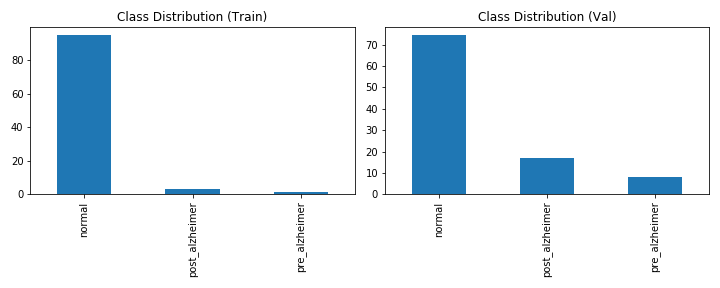

The validation set (and presumably the test set) has a different class distribution to the training data. In this notebook we will look at many different ways we can correct for this class imbalance - picking one of these will boost your score tremendously (we're taking ~0.66 with a single simple random forest model). So, let's dive in.

# Setup

Importing the libraries we'll be using, loading the data and getting ready to run our experiments.

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import f1_score, log_loss
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [2]:
#The training data
df = pd.read_csv('ds_shared_drive/train.csv')
print(df.shape)
df.head(2)

(32777, 122)


row_id  number_of_digits  missing_digit_1  missing_digit_2  \
0  S0CIXBKIUEOUBNURP              12.0              0.0              0.0   
1  IW1Z4Z3H720OPW8LL              12.0              0.0              0.0   

   missing_digit_3  missing_digit_4  missing_digit_5  missing_digit_6  \
0              0.0              0.0              0.0              0.0   
1              0.0              0.0              0.0              0.0   

   missing_digit_7  missing_digit_8  ...  bottom_area_perc  left_area_perc  \
0              0.0              0.0  ...           0.52617        0.524975   
1              0.0              0.0  ...           0.00081        0.516212   

   right_area_perc  hor_count  vert_count  eleven_ten_error  other_error  \
0         0.474667          0           0                 0            1   
1         0.483330          0           1                 0            1   

   time_diff  centre_dot_detect  diagnosis  
0     -105.0                0.0     normal  
1        NaN                NaN     normal  

[2 rows x 122 columns]

In [3]:
# The validation data (we merge in the labels for convenience)
val = pd.read_csv('ds_shared_drive/validation.csv')
val = pd.merge(val, pd.read_csv('ds_shared_drive/validation_ground_truth.csv'), 
               how='left', on='row_id')
print(val.shape)
val.head()

(362, 122)


row_id  number_of_digits  missing_digit_1  missing_digit_2  \
0  LA9JQ1JZMJ9D2MBZV              11.0              0.0              0.0   
1  PSSRCWAPTAG72A1NT               6.0              1.0              1.0   
2  GCTODIZJB42VCBZRZ              11.0              0.0              0.0   
3  7YMVQGV1CDB1WZFNE               3.0              1.0              0.0   
4  PHEQC6DV3LTFJYIJU               1.0              1.0              1.0   

   missing_digit_3  missing_digit_4  missing_digit_5  missing_digit_6  \
0              0.0              0.0              0.0              0.0   
1              0.0              1.0              1.0              0.0   
2              0.0              0.0              1.0              0.0   
3              1.0              0.0              1.0              1.0   
4              1.0              1.0              1.0              1.0   

   missing_digit_7  missing_digit_8  ...  bottom_area_perc  left_area_perc  \
0              0.0              0.0  ...          0.499368        0.553194   
1              0.0              0.0  ...          0.427196        0.496352   
2              0.0              0.0  ...          0.505583        0.503047   
3              1.0              1.0  ...          0.444633        0.580023   
4              1.0              0.0  ...          0.395976        0.494990   

   right_area_perc  hor_count  vert_count  eleven_ten_error  other_error  \
0         0.446447          0           0                 0            1   
1         0.503273          0           1                 0            1   
2         0.496615          1           0                 0            0   
3         0.419575          0           1                 0            1   
4         0.504604          0           0                 0            1   

   time_diff  centre_dot_detect       diagnosis  
0        NaN                NaN  post_alzheimer  
1        NaN                NaN          normal  
2        0.0                0.0          normal  
3        NaN                NaN  post_alzheimer  
4      150.0                0.0          normal  

[5 rows x 122 columns]

In [4]:
# We'll keep track of how different approaches perform
results = []

# Baseline #1 - Training on all data

This is a case where we don't do any correction for the class imbalance. Some models will do better than others - tree-based models like CatBoost will be less sensitive than some other model types, but they will still over-estimate the probability that a given sample will fall into the majority class when making predicitons on the validation set (since the 'normal' class is so much more common in the training data). 

In [5]:
# Prep the data
X = df.drop(['row_id', 'diagnosis'], axis=1).fillna(0)
y = df['diagnosis']
X_val = val.drop(['row_id', 'diagnosis'], axis=1).fillna(0)
y_val = val['diagnosis']

# Train the model
model = CatBoostClassifier(verbose=False, cat_features=['intersection_pos_rel_centre'])

# Evaluate on val set
model.fit(X, y, eval_set = (X_val, y_val), early_stopping_rounds = 30)

# Store results
r = {'Approach':'No modifications', 
     'Log Loss':log_loss(y_val, model.predict_proba(X_val)),
     'F1':f1_score(y_val, model.predict(X_val), average='macro') 
    }
results.append(r)

print(r) # Show results

{'Approach': 'No modifications', 'Log Loss': 0.6745549053231596, 'F1': 0.2848101265822785}


A log loss of 0.67 on the validation set isn't terrible. We are using the validation set for early stopping - without that in place we get a log loss of 0.78 on our validation set and 0.8X on the leaderboard. So in a way, by using the validation set for early stopping we are already starting to combat our class balance problem... but we can do much better!

# Adjusting Sample Weights

Models like CatBoost allow us to assign more weight to specific samples. In this case, we use this to place less weight on samples in the over-represented classes, combating the bias introduced by the imbalance: 

In [6]:
# Prep the data
X = df.drop(['row_id', 'diagnosis'], axis=1).fillna(0)
y = df['diagnosis']
X_val = val.drop(['row_id', 'diagnosis'], axis=1).fillna(0)
y_val = val['diagnosis']

#Our class weights
weights = {
    'normal':9/74, # Chosen based on some quick mental maths comparing the distribution of train vs val
    'post_alzheimer':0.85,
    'pre_alzheimer':1
}

# Applying these weights as sample weights by using Pool to wrap our training data
train_data = Pool(
    data = X,
    label = y,
    weight = y.map(weights), # << The important bit
    cat_features = [list(X.columns).index('intersection_pos_rel_centre')]
)

eval_data = Pool(
    data = X_val,
    label = y_val,
    weight = y_val.map(lambda x: 1.0), # all validation samples get a weight of 1
    cat_features = [list(X.columns).index('intersection_pos_rel_centre')]
)

# Train the model
model = CatBoostClassifier(verbose=False)

# Evaluate on val set
model.fit(train_data, eval_set = eval_data, early_stopping_rounds = 30)

# Store results
r = {'Approach':'Modifying Sample Weights', 
     'Log Loss':log_loss(y_val, model.predict_proba(X_val)),
     'F1':f1_score(y_val, model.predict(X_val), average='macro') 
    }
results.append(r)

print(r) # Show results

{'Approach': 'Modifying Sample Weights', 'Log Loss': 0.5593949556085255, 'F1': 0.4727603953181218}


As you can see, we're now getting a log loss of **0.56** on our validation set - a significant improvement! This approach is especially appealing since we don't throw out any data. However, not all models support sample weights. Next, let us investigate techniques for over- and under-sampling.

# SMOTE

Look for resources on training with imbalanced data and odds are high you will encounter **Synthetic Minority Oversampling Technique** (SMOTE). This is a technique for synthesizing additional samples for the under-represented classes. You can check out [this link](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/) for an more info.

Applying it is fairly simple. In this case, we run an experiment using SMOTE (from the imblearn library) to generate larger and larger numbers of synthetic examples, controlled by the *factor* parameter. 

In [7]:
for factor in [2, 4, 6, 10, 15, 20, 30, 40]:
    # Prep the data
    X = df.drop(['row_id', 'diagnosis', 'intersection_pos_rel_centre'], axis=1).fillna(0)
    y = df['diagnosis']
    X_val = val.drop(['row_id', 'diagnosis', 'intersection_pos_rel_centre'], axis=1).fillna(0)
    y_val = val['diagnosis']

    # SMOTE on the training data
    oversample = SMOTE(sampling_strategy={
        'normal':31208,
        'post_alzheimer':1149*factor,
        'pre_alzheimer':420*factor
    })
    X, y = oversample.fit_resample(X, y)

    # Train the model
    model = CatBoostClassifier(verbose=False)

    # Evaluate on val set
    model.fit(X, y, eval_set = (X_val, y_val), early_stopping_rounds = 30)

    # Store results
    r = {'Approach':f'SMOTE (factor of {factor})', 
         'Log Loss':log_loss(y_val, model.predict_proba(X_val)),
         'F1':f1_score(y_val, model.predict(X_val), average='macro') 
        }
    results.append(r)

    print(r) # Show results

{'Approach': 'SMOTE (factor of 2)', 'Log Loss': 0.6521451124388101, 'F1': 0.29584350028090123}
{'Approach': 'SMOTE (factor of 4)', 'Log Loss': 0.6371260967092448, 'F1': 0.3169377522318699}
{'Approach': 'SMOTE (factor of 6)', 'Log Loss': 0.6272541505942832, 'F1': 0.3445360195360196}
{'Approach': 'SMOTE (factor of 10)', 'Log Loss': 0.6178523829621976, 'F1': 0.346937773193851}
{'Approach': 'SMOTE (factor of 15)', 'Log Loss': 0.6120448842672219, 'F1': 0.3520166536559979}
{'Approach': 'SMOTE (factor of 20)', 'Log Loss': 0.6000621132749585, 'F1': 0.3755389762582076}


/home/jonathan/anaconda3/lib/python3.7/site-packages/imblearn/utils/_validation.py:326: UserWarning: After over-sampling, the number of samples (34470) in class post_alzheimer will be larger than the number of samples in the majority class (class #normal -> 31208)
  n_samples_majority,


{'Approach': 'SMOTE (factor of 30)', 'Log Loss': 0.6031935307693084, 'F1': 0.40465015210777927}


/home/jonathan/anaconda3/lib/python3.7/site-packages/imblearn/utils/_validation.py:326: UserWarning: After over-sampling, the number of samples (45960) in class post_alzheimer will be larger than the number of samples in the majority class (class #normal -> 31208)
  n_samples_majority,


{'Approach': 'SMOTE (factor of 40)', 'Log Loss': 0.606239826680783, 'F1': 0.41754719279015956}


At some point we start getting warnings that we've generated so many synthetic examples that one of our minority classes now outnumbers the original majority class. Up to a point, generating more synthetic samples does increase the performance, with our top score being **~0.59** - an improvement over our baseline but not as good as the previous approach.

SMOTE isn't often used in isolation - instead, we typically see it in conjunction with some undersampling. Let's try that next:

# Oversampling + Undersampling

imblearn's `Pipeline` makes it easy to chain together multiple stages. First, we use SMOTE to synthetically 'oversample' our smaller classes, then we use the `RandomUnderSampler` to undersample the 'normal' class while keeping all the synthetic samples of the smaller classes. You can tweak the amout - in this example we create 5x the examples from the smaller classes and cut the number of samples down to 25%.

In [8]:
# Prep the data
X = df.drop(['row_id', 'diagnosis', 'intersection_pos_rel_centre'], axis=1).fillna(0)
y = df['diagnosis']
X_val = val.drop(['row_id', 'diagnosis', 'intersection_pos_rel_centre'], axis=1).fillna(0)
y_val = val['diagnosis']

# SMOTE on the training data
over = SMOTE(sampling_strategy={
    'normal':31208,
    'post_alzheimer':1149*5,
    'pre_alzheimer':420*5
})
under = RandomUnderSampler(sampling_strategy={
    'normal':int(31208/4), # keeping 25%
    'post_alzheimer':1149*5, # Keeping all of the samples we generated in the previous step
    'pre_alzheimer':420*5
})
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
X, y = pipeline.fit_resample(X, y)

# Train the model
model = CatBoostClassifier(verbose=False)

# Evaluate on val set
model.fit(X, y, eval_set = (X_val, y_val), early_stopping_rounds = 30)

# Store results
r = {'Approach':f'Over (10) + under (3)', 
     'Log Loss':log_loss(y_val, model.predict_proba(X_val)),
     'F1':f1_score(y_val, model.predict(X_val), average='macro') 
    }
results.append(r)

print(r) # Show results

{'Approach': 'Over (10) + under (3)', 'Log Loss': 0.5799389927231922, 'F1': 0.4556547491919753}


Pretty good - and you could improve this further with a little extra tweaking. 

Now on to the strategy I've actually been using in m submissions:

# An Unreasonably Good Strategy...

After all of the above, we come back to the approach I first took when I noticed there was a class imbalance and it was different between the train set and the val set... just throwing out most of the samples for the majority class. The code is simple - we just take a small (~17% in this case) sample of the rows diagnosed as 'normal'. It turns out this is one of the best strategies, outperforming all the attempts at oversampling and nearly beating our entry with modified sample weights. A benefit of this approach is that it works even when your model doesn't support sample weights - for example, I have used this with a simple Random Forest Classifier with great results.

In [9]:
df_us = pd.concat([
    df.loc[df.diagnosis == 'pre_alzheimer'],
    df.loc[df.diagnosis == 'post_alzheimer'],
    df.loc[df.diagnosis == 'normal'].sample(frac=1/6),
]).reset_index().drop('index', axis=1)

X = df_us.drop(['row_id', 'diagnosis'], axis=1).fillna(0)
y = df_us['diagnosis']
X_val = val.drop(['row_id', 'diagnosis'], axis=1).fillna(0)
y_val = val['diagnosis']

# Train the model
model = CatBoostClassifier(verbose=False, cat_features=['intersection_pos_rel_centre'])

# Evaluate on val set
model.fit(X, y, eval_set = (X_val, y_val), early_stopping_rounds = 30)

# Store results
r = {'Approach':'Just throw away some of the majority class samples', 
     'Log Loss':log_loss(y_val, model.predict_proba(X_val)),
     'F1':f1_score(y_val, model.predict(X_val), average='macro') 
    }
results.append(r)

print(r) # Show results

{'Approach': 'Just throw away some of the majority class samples', 'Log Loss': 0.5569981832627415, 'F1': 0.4683894696089818}


It's a little annoying how good this does - despite lots of tweaking I have yet to find anything that consistently does much better than this! Good news for all of you reading this too - simply copy the first few lines to transform your training dataset then carry on with whatever models you were previously using :) 

# View our results

Taking a look at the final table of results, we can see that there are several approaches that do well, but ultimately ANYTHING that addresses the class imbalance problem will give a big boost over naively training on all of the data.

In [10]:
pd.DataFrame(results).sort_values(by='Log Loss')

Approach  Log Loss        F1
11  Just throw away some of the majority class sam...  0.556998  0.468389
1                            Modifying Sample Weights  0.559395  0.472760
10                              Over (10) + under (3)  0.579939  0.455655
7                                SMOTE (factor of 20)  0.600062  0.375539
8                                SMOTE (factor of 30)  0.603194  0.404650
9                                SMOTE (factor of 40)  0.606240  0.417547
6                                SMOTE (factor of 15)  0.612045  0.352017
5                                SMOTE (factor of 10)  0.617852  0.346938
4                                 SMOTE (factor of 6)  0.627254  0.344536
3                                 SMOTE (factor of 4)  0.637126  0.316938
2                                 SMOTE (factor of 2)  0.652145  0.295844
0                                    No modifications  0.674555  0.284810

# Conclusions

I hope you've found this interesting. If you use this and get better results, please let me know! And if you have corrections, suggestions or other techniques that have worked for you, please share them in the discussions and let's all learn together.

Good luck! 

Jonathan (@johnowhitaker)

# Appendix

Producing the plot of class distribution:

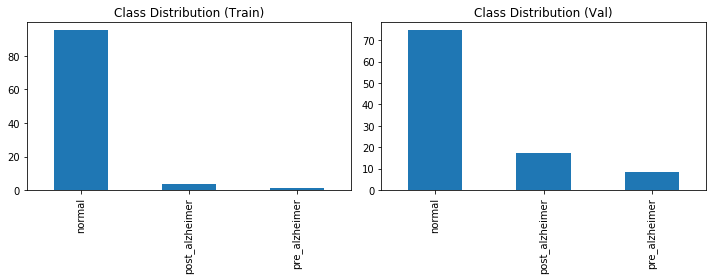

In [11]:
from matplotlib import pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
(df['diagnosis'].value_counts()*100/len(df)).plot(kind='bar', ax=ax1, title='Class Distribution (Train)')
(val['diagnosis'].value_counts()*100/len(val)).plot(kind='bar', ax=ax2,  title='Class Distribution (Val)')
plt.tight_layout()
plt.savefig('Class balance.png')